# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [3]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [4]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(8.8, '2023-12-05')

(9.53,
 59    2024-03-06
 Name: date, dtype: object)

9 0.18 1.61
Bull
1.61


### regression_line(X, Y)
regression_ratio(df, window=10):

8.75 -0.02
Above
-0.02


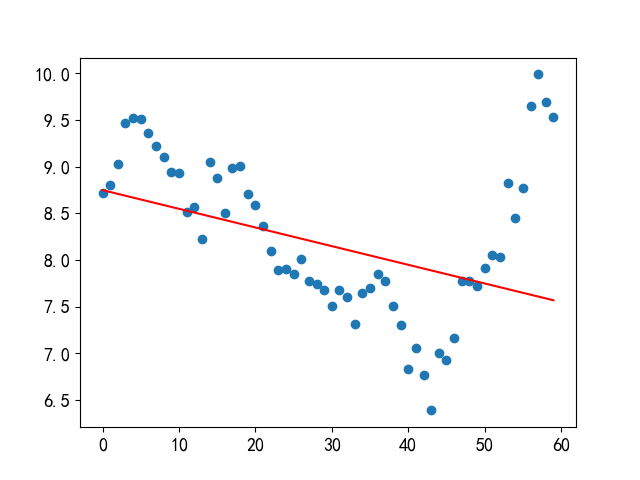

In [5]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

8.75 -0.02
Above
-0.02


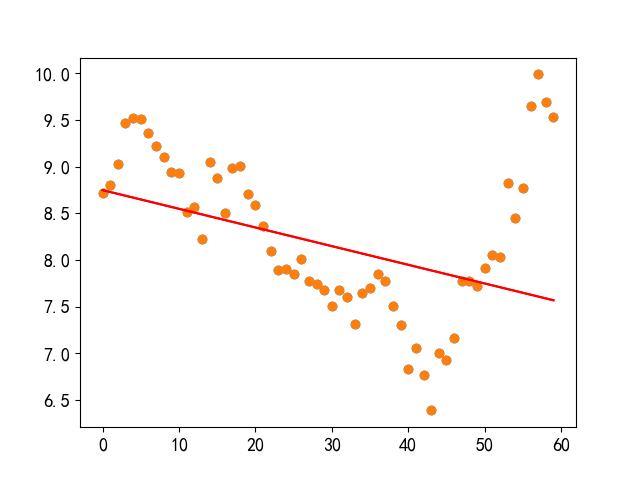

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [7]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'max5', 'hmax', 'high4', 'low4', 'lastdu4', 'lmin', 'min5', 'cmean',
       'hv', 'lv'],
      dtype='object', length=183)

### check_postion_vol_price

In [8]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code  open  high   low  close          vol        amount  \
59  2024-03-06  601360  9.51   9.7  9.37   9.53  200094392.0  1.906219e+09   

    ma5d  ma10d  ...  hmax  high4  low4  lastdu4  lmin  min5  cmean  \
59  9.53   8.89  ...  9.17   10.2  8.43     1.21  6.19  8.43   8.34   

             hv          lv  Positon  
59  336581112.0  54934971.0  Neutral  

[1 rows x 184 columns]

In [9]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'hmax', 'high4', 'low4', 'lastdu4', 'lmin', 'min5', 'cmean', 'hv', 'lv',
       'Positon'],
      dtype='object', length=184)

0    2023-12-05
1    2023-12-06
2    2023-12-07
Name: date, dtype: object

59   2024-03-06
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:-0.02 
code: 601360


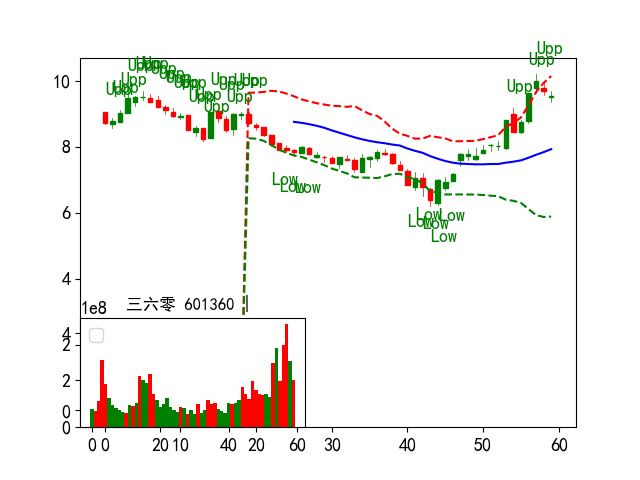

In [10]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [11]:
'code' in dfc.columns

True

### show_channel_mpl

In [12]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [13]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [14]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [15]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 4958
1.97 (4958,) 603388 (341, 6)
resample:D
use time:11.83


In [16]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close          vol        amount
date                                                          
2024-03-06  9.39  9.45  9.27   9.33  103860159.0  9.713139e+08

### Test InStock

In [17]:
df.loc['301083'][:2]

open   high    low  close        vol      amount
date                                                         
2022-10-12  10.83  11.34  10.66  11.28  1111100.0  12353461.0
2022-10-13  11.28  11.59  11.27  11.47   787700.0   9055665.0

## ra_diff

In [18]:
tail_days = 60

In [19]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [20]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [21]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [22]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [23]:
# df.loc['000002'][-10:]

## sina_dm

In [24]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2024-03-05',
 code
 000590    启迪药业
 Name: name, dtype: object)

In [25]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2024-03/06/24 20:53:33'

code
603580   2024-03-06 15:00:01
601777   2024-03-06 15:00:01
Name: ticktime, dtype: datetime64[ns]

353.5446146051089

### Combine ratio and idx

In [26]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [27]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [28]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
h5code='603019'
h5.loc[h5code][-3:]
code_muti = '603019'
# h5.loc[code_muti][:2]

freq = 'D'
# freq = '5M'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
# run_col = ['close']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol = round(allvol / 10 / 1000 / 1000,2)
print("总量:%s 亿"%(allvol))
mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
#全局占比
mdf['volume'] = mdf.amount.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')
mdf.loc[h5code]

['/all_20']
G:\sina_MultiIndex_data.h5


(5526546, 6)

close  high    low  llastp     volume  lastbuy
ticktime                                                           
2024-03-06 14:59:33   54.5  55.4  51.68   52.94  169191094    54.10
2024-03-06 14:59:46   54.5  55.4  51.68   52.94  169191094    55.48
2024-03-06 15:00:00   54.5  55.4  51.68   52.94  171358664    52.88

1.0

总量:7963.09 亿


ticktime    2024-03-07 00:00:00
close                 53.649855
volume                     1.15
vol                      171.36
amount                    91.93
Name: 603019, dtype: object

In [29]:
mdf[:2]
mdf.loc['603019']

ticktime      close  volume     vol  amount
code                                                
000001 2024-03-07  10.382772    0.18  134.56   13.97
000002 2024-03-07   9.350399    0.12  103.86    9.71

ticktime    2024-03-07 00:00:00
close                 53.649855
volume                     1.15
vol                      171.36
amount                    91.93
Name: 603019, dtype: object

In [30]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2024-03-06'

In [31]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2024-03-07 00:00:00
close                  9.350399
volume                     0.12
vol                      103.86
amount                     9.71
Name: 000002, dtype: object

###  实时成交量个股Top

In [32]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [33]:
nowdf.shape,top20_nd

((4896, 5),
         volume  name
 code                
 601127    1.19   赛力斯
 603019    1.15  中科曙光
 000063    0.83  中兴通讯
 000977    0.78  浪潮信息
 000628    0.71  高新发展
 300308    0.64  中际旭创
 601138    0.64  工业富联
 002456    0.60   欧菲光
 300364    0.60  中文在线
 002281    0.59  光迅科技
 000938    0.52  紫光股份
 301236    0.50  软通动力
 600519    0.47  贵州茅台
 002230    0.45  科大讯飞
 002475    0.44  立讯精密
 002236    0.43  大华股份
 002611    0.42  东方精工
 000625    0.42  长安汽车
 603259    0.41  药明康德
 300274    0.41  阳光电源)

### 合并实时成交量及SinaDM

In [34]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm[:1]

name  open  llastp  now  trade  high   low  buy  sell   volume  ...  \
code                                                                    ...   
000590  启迪药业  6.44    6.44  6.5    0.0  6.55  6.32  6.5  6.51  5290564  ...   

        close     nvol         timel   lastbuy  nlow  nhigh  nclose  nstd  \
code                                                                        
000590    6.5  5290564  1.709709e+09  6.468025  6.38    6.5    6.47  -2.0   

         vol  amount  
code                  
000590  5.29    0.34  

[1 rows x 44 columns]

## check HDF LastDate

In [35]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(4891, 7)

(67, 7)

In [36]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open   high    low  close        vol       amount  ra_diff
code   date                                                                   
689009 2023-12-29  29.25  30.14  29.25  29.66  3923048.0  116933801.0     1.06

In [37]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [38]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [39]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [40]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [41]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2024-03-05   8.27   8.93  8.26  8.19
2024-03-06   8.28   8.92  8.22  8.18

Empty DataFrame
Columns: [open, high, low, close, vol, amount, ra_diff, ma10, ma5, ma20, ma250, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d]
Index: []

[0 rows x 28 columns]

(60, 28)


In [42]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff     hat    close  volsum5d     hmax    lmin  perc1d  \
date                                                                      
2024-03-05     1.07  161.21  1695.10      65.9  1737.93  1581.0    1.12   
2024-03-06     1.07  150.69  1680.55     -17.3  1737.93  1581.0   -0.86   

               ma20   ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  \
date                                                                     
2024-03-05  1673.95  405.33  36.83  -1.43   8.52 -22.31  44.33    0.01   
2024-03-06  1677.32  412.01 -38.90  36.83  -1.43   8.52 -22.31   -0.27   

            perc5d   ma51d  ra_diff  
date                                 
2024-03-05    0.33  1686.6     1.07  
2024-03-06   -0.06  1686.4     1.07

### Append Now SinaTo MultiIndex dfNow

In [43]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

open   high    low  close          vol        amount  \
code   date                                                               
000001 2024-03-05  10.3  10.47  10.26  10.43  181731907.0  1.889144e+09   
       2024-03-06  10.4  10.45  10.33  10.33  134564016.0  1.396940e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  \
code   date                                      ...                           
000001 2024-03-05     1.16  10.59  10.47  10.08  ...   -1.51   -0.57   -0.67   
       2024-03-06     1.14  10.54  10.43  10.12  ...   -1.53   -2.46   -1.53   

                   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  
code   date                                                            
000001 2024-03-05   9.75  -9.42  -0.93 -40.14  55.54      14.8  10.47  
       2024-03-06 -25.95   9.75  -9.42  -0.93 -40.14     -66.7  10.43  

[2 rows x 29 columns]

In [44]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close          vol        amount  ra_diff  ma10  \
date                                                                            
2024-03-06  9.39  9.45  9.27   9.33  103860159.0  9.713139e+08     1.03  9.85   

             ma5  ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  vol3d  \
date                    ...                                                
2024-03-06  9.63  9.77  ...   -5.66   -7.07   -6.04 -35.31 -20.29  84.34   

            vol4d  vol5d  volsum5d  ma51d  
date                                       
2024-03-06   -1.9  -9.64      17.2   9.63  

[1 rows x 29 columns]

### Xratio and tail 60 MultiIndex 

In [45]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [46]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                        
2023-12-05  39.63  39.85  38.35  38.39  42876714.0  1.667102e+09     1.28   

            ma10    ma5  ma20  ...  perc3d  perc4d  perc5d    vol1d  vol2d  \
date                           ...                                           
2023-12-05  9.95  13.03  8.18  ...  471.28  461.26   462.9  1201.07  16.16   

            vol3d  vol4d  vol5d  volsum5d  ma51d  
date                                              
2023-12-05  -14.0  -4.72 -40.63    1157.9  13.03  

[1 rows x 29 columns]

## DFNow Query check

In [47]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2024-03-05


code    date      
300757  2024-03-06    2.25
300492  2024-03-06    1.31
603129  2024-03-06    0.96
601799  2024-03-06    0.84
605117  2024-03-06    0.76
300474  2024-03-06    0.75
301030  2024-03-06    0.59
300474  2024-03-05    0.59
002281  2024-03-06    0.55
002865  2024-03-06    0.47
Name: xratio, dtype: float64

date
2024-02-26     NaN
2024-02-27   -0.11
2024-02-28   -0.10
2024-02-29   -0.05
2024-03-01    0.01
2024-03-04    0.05
2024-03-05    0.09
2024-03-06    0.12
Name: close, dtype: float64

In [48]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2024-03-05    5.11
2024-03-06    5.15
Name: upper, dtype: float64

(60, 29)
xratio:-0.03 ra_diff:1.42
code: 300459


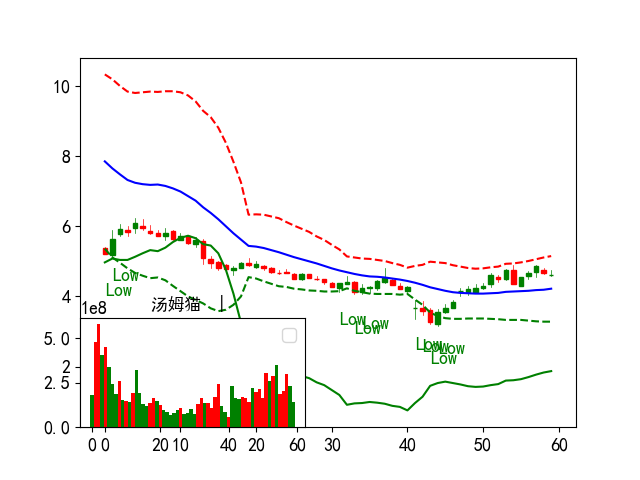

In [49]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

601127 date
2024-03-05    1.62
2024-03-06    1.73
Name: ra_diff, dtype: float64
xratio:-0.05 ra_diff:1.73
code: 601127


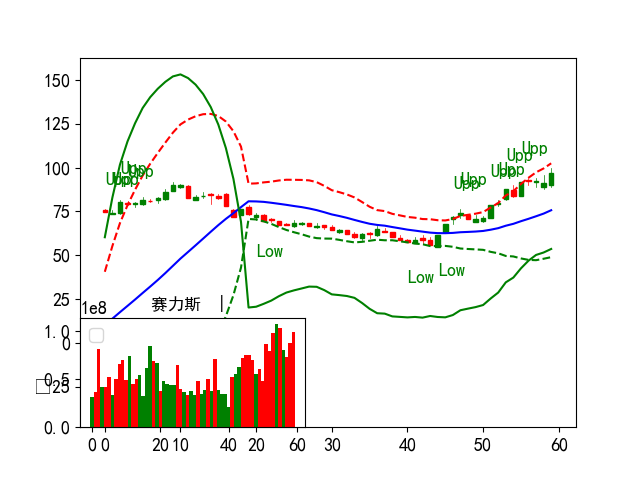

603019 date
2024-03-05    1.76
2024-03-06    1.81
Name: ra_diff, dtype: float64
xratio:0.07 ra_diff:1.81
code: 603019


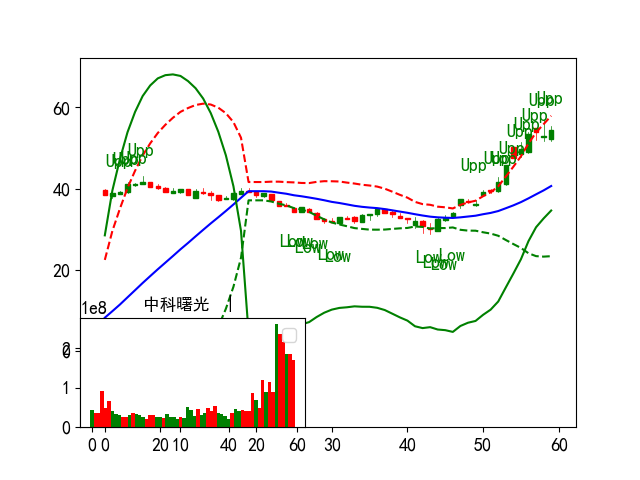

In [50]:
for co in top20_nd.index[:2]:
    print(co,dfNow.loc[co].ra_diff[-2:])
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)

In [51]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date  open   high    low  close        vol      amount  ra_diff  \
code                                                                           
688799 2024-03-06  44.2  45.28  43.30  44.38  1150876.0  50991280.0     1.43   
688793 2024-03-06  26.9  29.19  26.85  28.45  1583705.0  44958465.0     1.14   

         ma10    ma5  ...  perc5d   vol1d  vol2d  vol3d  vol4d  vol5d  \
code                  ...                                               
688799  43.12  44.31  ...    6.30    6.01   6.90  28.13 -25.16 -32.62   
688793  28.08  27.64  ...    3.95  187.16  10.78   9.52 -46.77 -25.98   

        volsum5d  ma51d  xratio   idx  
code                                   
688799     -16.7  44.31    0.31  4.35  
688793     134.7  27.64   -0.03  0.73  

[2 rows x 32 columns]

In [52]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [53]:
df.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff
date                                                                   
2024-03-05  9.32  9.49  9.20   9.48  160544446.0  1.501309e+09     1.05
2024-03-06  9.39  9.45  9.27   9.33  103860159.0  9.713139e+08     1.03

In [54]:
dfNow.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff  ma10  \
date                                                                            
2024-03-05  9.32  9.49  9.20   9.48  160544446.0  1.501309e+09     1.05  9.94   
2024-03-06  9.39  9.45  9.27   9.33  103860159.0  9.713139e+08     1.03  9.85   

             ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                    ...                                              
2024-03-05  9.75  9.79  ...   -5.77 -20.29  84.34  -1.90  -9.64  46.94   
2024-03-06  9.63  9.77  ...   -6.04 -35.31 -20.29  84.34  -1.90  -9.64   

            volsum5d  ma51d  xratio   idx  
date                                       
2024-03-05      99.5   9.75    0.01 -0.73  
2024-03-06      17.2   9.63   -0.00 -0.82  

[2 rows x 31 columns]

# 基础处理

In [55]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2024-02-05 2024-03-06


open   high    low  close          vol        amount  \
code   date                                                               
000001 2024-03-05  10.3  10.47  10.26  10.43  181731907.0  1.889144e+09   
       2024-03-06  10.4  10.45  10.33  10.33  134564016.0  1.396940e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2024-03-05     1.16  10.59  10.47  10.08  ...   -0.67   9.75  -9.42   
       2024-03-06     1.14  10.54  10.43  10.12  ...   -1.53 -25.95   9.75   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2024-03-05  -0.93 -40.14  55.54      14.8  10.47    0.06 -0.37  
       2024-03-06  -9.42  -0.93 -40.14     -66.7  10.43    0.06 -0.57  

[2 rows x 31 columns]

Low:2024-02-05


Timestamp('2024-02-05 00:00:00')

In [56]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(12913, 31)
count dd.couts
(code    date      
603979  2024-02-05    17
603960  2024-02-05    17
601899  2024-02-05    17
601607  2024-02-05    17
601138  2024-02-05    17
Name: couts, dtype: int64, (12913, 32))
dt_low:2024-02-05 df:891 Index(['603979', '603960', '601899', '601607', '601138'], dtype='object', name='code') df_idx:511
Main Down dd :1 MainUP df:891 couts std:3.8 
time: 0.03  844


In [57]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close        vol      amount  ra_diff   ma10  \
date                                                                            
2024-03-06  15.85  16.14  15.62  15.85  4531760.0  71911566.6     1.32  15.75   

              ma5   ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                      ...                                              
2024-03-06  16.02  14.71  ...    5.25 -31.42    8.1  -20.3  -2.82 -31.13   

            volsum5d  ma51d  xratio   idx  
date                                       
2024-03-06     -77.6  16.02    0.09  0.76  

[1 rows x 31 columns]

## 最近60天筛选

In [58]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [59]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(1235, 31)
count dd.couts
(code    date      
000685  2024-01-18    14
Name: couts, dtype: int64, (1235, 32))
(code    date      
601108  2024-02-28    14
000685  2024-03-06    14
Name: couts, dtype: int64, (352, 32))
Count:352 32


couts  ra_diff  xratio  idx   hat  close  volsum5d   hmax  \
code   date                                                                    
000017 2024-02-20      1     2.62     0.0  0.0  5.94  11.07     -22.6  14.88   
600847 2024-01-17      1     2.03     0.0  0.0  1.12  11.38     -90.7  12.12   
600213 2024-01-19      1     2.00     0.0  0.0  1.04   8.49     -36.4   9.93   

                    lmin  perc1d   ma20  ma250  vol1d  vol2d  vol3d  vol4d  \
code   date                                                                  
000017 2024-02-20   7.93   10.04  11.06  10.28 -13.12   1.72   6.85 -28.50   
600847 2024-01-17  10.83   10.38  10.52  10.84 -52.53 -33.91   4.49  17.86   
600213 2024-01-19   8.37   -1.51   7.84   7.89 -42.00  70.08 -44.14   1.40   

                   vol5d  perc3d  perc5d  
code   date                               
000017 2024-02-20  10.45    3.94   -3.74  
600847 2024-01-17 -26.62    8.80    6.45  
600213 2024-01-19 -21.71    4.56    3.28

#### filter today

In [60]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [61]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [62]:
dfs.loc['301073'][-5:].ra_diff

date
2024-02-29    1.24
2024-03-01    1.24
2024-03-04    1.25
2024-03-05    1.26
2024-03-06    1.27
Name: ra_diff, dtype: float64

xratio:-0.02 ra_diff:1.03
code: 000002


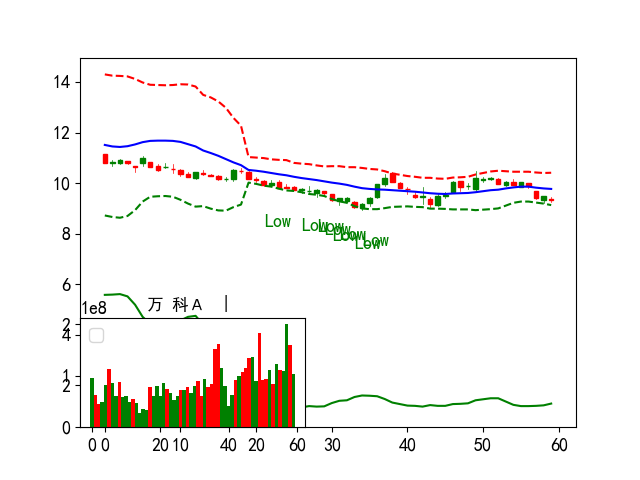

In [63]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [64]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [65]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2024-03-04    1.12
        2024-03-05    1.13
        2024-03-06    1.12
399001  2024-03-04    1.19
        2024-03-05    1.18
        2024-03-06    1.18
399006  2024-03-04    1.18
        2024-03-05    1.18
        2024-03-06    1.18
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [66]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 31


ra_diff  xratio   idx   hat  close  volsum5d   hmax  lmin  perc1d  \
date                                                                            
2024-03-05     1.48   -0.00  2.78  4.75  14.33      17.7  14.33  9.25    9.98   
2024-03-06     1.62    0.05  3.83  5.85  15.76      16.7  15.76  9.25    9.98   

             ma20  ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  
date                                                                         
2024-03-05  11.91  12.71  79.61 -31.32   7.32 -36.17  -1.74   12.66    6.23  
2024-03-06  12.08  12.72  -2.75  79.61 -31.32   7.32 -36.17   19.03   29.82

## !!! Run-Filter强势Upper

### !!! filterRule test

In [67]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 -0.03 -0.23


'Bear'

-0.23

date
2024-02-29    0.03
2024-03-01    0.02
2024-03-04    0.02
2024-03-05    0.01
2024-03-06    0.01
Name: xratio, dtype: float64

xratio:0.02 ra_diff:1.17
code: 601728


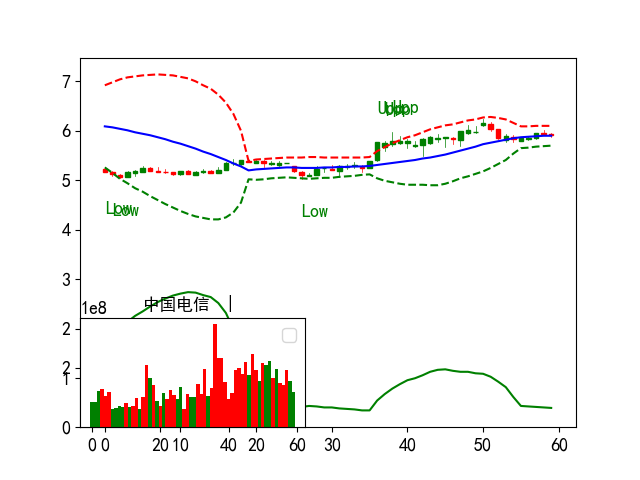

In [68]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [69]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高

30
xratio:0.06 ra_diff:1.29
code: 600012


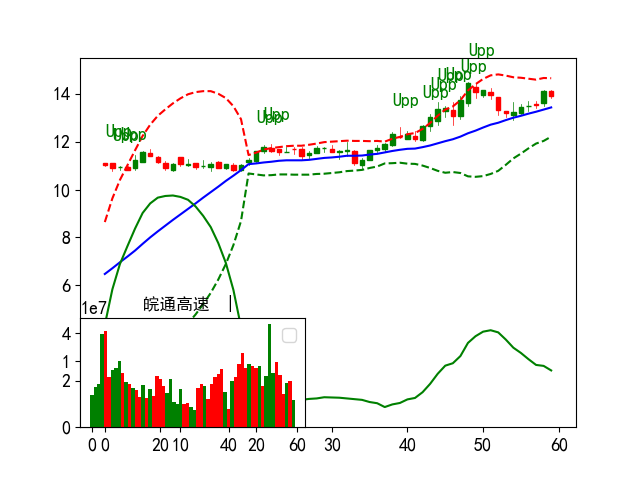

In [70]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [71]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)[:10]
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 601225    14
 Name: couts, dtype: int64,
 (361, 41))

Count:361 41


name  couts       date  perc  ra_diff  xratio    idx    hat   close  \
code                                                                          
601225  陕西煤业     14 2024-03-06  0.41     1.41    0.16   0.17   4.54   27.08   
600104  上汽集团     13 2024-03-05 -1.12     1.16    0.07   0.45   2.04   15.01   
000157  中联重科     13 2024-03-06  2.86     1.33    0.04   0.12   1.22    8.26   
601009  南京银行     13 2024-03-06  0.45     1.25    0.03   0.14   0.83    8.87   
601699  潞安环能     13 2024-03-06  2.85     1.32    0.20   2.29   5.91   28.18   
300394  天孚通信     13 2024-03-05 -0.05     1.65    2.32  12.60  66.58  135.53   
601607  上海医药     13 2024-03-06 -0.54     1.20    0.08   0.60   2.17   18.56   
600350  山东高速     13 2024-03-06 -1.19     1.21    0.04  -0.06   1.01    8.30   
000528   柳 工     12 2024-03-05  0.00     1.29    0.05   0.32   1.39    7.99   
600660  福耀玻璃     12 2024-03-05 -1.76     1.27    0.29   4.41   7.55   45.32   

        volsum5d  ...  ma250  nclose    llow   vol1d   vol2d  vol3d  vol4d  \
code              ...                                                        
601225     -11.2  ...   9.82   27.31   26.70    6.11    0.78   2.36  -7.42   
600104     100.8  ...   7.35   15.11   14.87   60.98   13.26 -29.28  -1.10   
000157      58.0  ...   6.60    8.25    8.01  126.09  -13.15 -18.64 -12.41   
601009      50.6  ...   8.39    8.93    8.84  -20.62   89.54 -14.53  30.97   
601699      33.4  ...  13.91   27.95   27.35   37.50  -28.21   7.15  32.64   
300394      -5.0  ...  41.15  134.87  134.86   20.87  -14.93  -5.26  16.68   
601607     -11.1  ...   8.57   18.65   18.48  -36.64    8.71  46.60  -7.43   
600350     -36.2  ...   7.51    8.37    8.26   -7.60  -15.60  22.00  -9.21   
000528     267.2  ...   6.34    7.98    7.95   74.51  117.90  19.48 -35.26   
600660     152.8  ...  15.12   45.53   43.56  128.23    8.86 -46.28  19.96   

        vol5d  perc3d  perc5d  
code                           
601225 -13.04    4.84    3.48  
600104  56.99    1.47    1.95  
000157 -23.92    3.25    6.03  
601009 -34.76    1.84    2.31  
601699 -15.72    6.22    8.38  
300394 -22.37   -0.29    1.95  
601607 -22.39    1.92    4.27  
600350 -25.82    2.72    1.84  
000528  90.62    4.17    2.83  
600660  42.02    6.56   10.17  

[10 rows x 24 columns]

#### !!! hmax Top upper > 1

In [72]:
# dfs_tail9.loc['600103']

In [73]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['volsum5d', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])

show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1)] )[:10]

count dd.couts
compute percent
code
002369    3
Name: couts, dtype: int64 (189, 41)


(code
 002369    3
 Name: couts, dtype: int64,
 (189, 41))

Count:138 41


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
002369  卓翼科技      3 2024-03-06  -3.79     1.88    0.03   1.36   2.90   5.33   
002875   安奈儿      5 2024-03-06   9.98     2.69    0.28  10.75  14.84  21.26   
002881  美格智能      2 2024-03-05  -3.15     1.51    0.19   6.13  10.50  25.52   
600330  天通股份      2 2024-03-05   1.42     1.49    0.04   1.47   2.73   8.60   
603327  福蓉科技      4 2024-03-06  10.03     2.05    0.18   6.84   9.16  16.79   
600979  广安爱众      2 2024-03-06   3.57     1.31   -0.00   0.49   0.82   3.48   
002716  金贵银业      2 2024-03-05  -3.05     1.39    0.01   0.55   0.76   2.86   
001298   好上好      2 2024-03-06  10.00     1.94    0.18   8.08  13.54  29.05   
002632  道明光学      3 2024-03-06   3.12     1.63    0.04   2.12   3.32   8.25   
300411  金盾股份      2 2024-03-06  19.94     2.01   -0.02   2.97   3.57   7.64   

        volsum5d  ...  ma250  nclose   llow    vol1d    vol2d  vol3d  vol4d  \
code              ...                                                         
002369    1636.0  ...  64.46    5.43   5.12    -4.81  1760.46 -76.49 -18.88   
002875    1406.0  ...  16.63   21.26  21.26   -92.59  1536.50  34.56 -49.79   
002881    1300.9  ...  16.88   25.60  25.59  1382.51   -60.10 -18.91 -26.28   
600330     895.8  ...  11.46    8.52   8.41   944.57   -45.90  -2.94 -40.69   
603327     641.0  ...  10.25   16.79  16.44    58.39   623.83  68.60 -73.69   
600979     566.0  ...   6.44    3.59   3.44   528.75    89.09 -22.51   1.68   
002716     442.9  ...   7.28    2.86   2.91   285.61   125.42  -9.99  -7.81   
001298     417.0  ...  22.58   26.94  25.18   447.59   -65.65  48.33  13.04   
002632     394.0  ...   9.01    8.44   8.21   345.15   -30.32  91.32  30.53   
300411     355.6  ...  11.42    7.53   6.28    55.49   370.80 -16.70 -16.74   

        vol5d  perc3d  perc5d  
code                           
002369 -24.33   16.38   32.92  
002875 -22.73   33.12   61.06  
002881  23.67   18.43   15.37  
600330  40.80   13.22   10.56  
603327 -36.13   33.15   61.13  
600979 -31.00   13.73   17.97  
002716  49.71   17.53   18.00  
001298 -26.35   29.40   38.86  
002632 -42.63   24.81   35.47  
300411 -37.22   45.25   53.72  

[10 rows x 24 columns]

In [74]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [75]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')[:20]

Count:189 41


name  couts       date   perc  ra_diff  ra_diff  xratio    idx    hat  \
code                                                                            
300757  罗博特科      5 2024-03-06  12.86     2.87     2.87    2.25  58.41  94.77   
300290  荣科科技      4 2024-03-06  19.95     2.80     2.80    0.15   4.84   6.68   
002875   安奈儿      5 2024-03-06   9.98     2.69     2.69    0.28  10.75  14.84   
000628  高新发展      9 2024-03-06   1.91     2.67     2.67    2.23  35.04  74.80   
600715  文投控股      1 2024-03-06   9.83     2.22     2.22    0.00   0.92   1.48   
300780  德恩精工      2 2024-03-06  10.24     2.12     2.12    0.24   6.40  13.67   
600818  中路股份      3 2024-03-06   0.57     2.11     2.11    0.18   6.05  10.15   
603327  福蓉科技      4 2024-03-06  10.03     2.05     2.05    0.18   6.84   9.16   
300411  金盾股份      2 2024-03-06  19.94     2.01     2.01   -0.02   2.97   3.57   
002272  川润股份      2 2024-03-06   9.98     1.97     1.97    0.02   2.04   3.13   
001298   好上好      2 2024-03-06  10.00     1.94     1.94    0.18   8.08  13.54   
300492  华图山鼎      3 2024-03-06   3.84     1.90     1.90    1.31  15.29  35.94   
300735  光弘科技      4 2024-03-06   7.22     1.89     1.89    0.33   9.42  14.06   
002369  卓翼科技      3 2024-03-06  -3.79     1.88     1.88    0.03   1.36   2.90   
300475  香农芯创      4 2024-03-06   3.45     1.82     1.82    0.48   8.56  19.80   
000801  四川九洲      5 2024-03-06   9.97     1.81     1.81    0.12   3.72   5.60   
002877  智能自控      1 2024-03-05  -5.44     1.81     1.81    0.05   3.21   4.75   
601138  工业富联      5 2024-03-05  -3.25     1.79     1.79    0.35   5.20  10.64   
301213  观想科技      1 2024-03-06  10.68     1.76     1.76   -0.14  13.49  17.97   
002281  光迅科技      5 2024-03-05   6.85     1.75     1.75    0.45   9.55  18.08   

         close  ...  ma250  nclose    llow   vol1d    vol2d  vol3d   vol4d  \
code            ...                                                          
300757  122.88  ...  95.18  119.15  109.01   10.85   -14.50  15.82   44.25   
300290   10.04  ...   8.19    9.77    8.80  -16.94    70.18  84.58  -14.14   
002875   21.26  ...  16.63   21.26   21.26  -92.59  1536.50  34.56  -49.79   
000628   90.02  ...  14.88   89.05   86.50   -7.08    22.87  -4.73  -27.22   
600715    2.57  ...   4.78    2.54    2.27    5.61  1441.64 -71.89  -57.67   
300780   22.06  ...  48.32   22.16   21.23   27.58    36.40 -26.12   13.88   
600818   15.90  ...   7.21   16.35   15.20    0.34    17.32  31.07  -29.10   
603327   16.79  ...  10.25   16.79   16.44   58.39   623.83  68.60  -73.69   
300411    7.64  ...  11.42    7.53    6.28   55.49   370.80 -16.70  -16.74   
002272    6.61  ...   9.74    6.61    6.61  115.58   -49.33 -70.72    0.43   
001298   29.05  ...  22.58   26.94   25.18  447.59   -65.65  48.33   13.04   
300492  112.59  ...  27.70  111.56  107.26  -26.50    22.55  47.77  -23.18   
300735   27.18  ...  12.18   26.47   24.35  -15.84    19.93 -26.20   59.99   
002369    5.33  ...  64.46    5.43    5.12   -4.81  1760.46 -76.49  -18.88   
300475   37.82  ...  16.23   36.52   35.03   -0.35   -11.17  75.64  -17.28   
000801   12.35  ...   7.64   12.21   11.18    5.07    67.68 -29.68  274.48   
002877    9.90  ...  18.13    9.97    9.60   72.06   101.64 -14.71  -31.43   
601138   22.01  ...  11.73   22.06   21.53   15.50     8.09  35.96  -16.83   
301213   38.87  ...  16.85   38.05   36.18  246.78    76.56 -18.93  -18.95   
002281   37.90  ...  11.34   37.54   35.00   79.19   -15.22   5.43   58.39   

        vol5d  perc3d  perc5d  
code                           
300757  15.19   30.45   73.05  
300290 -28.77   62.20   63.25  
002875 -22.73   33.12   61.06  
000628   9.45   23.32   34.16  
600715 -27.02   32.47   46.86  
300780  -2.68   13.48   36.76  
600818 -13.42   21.65   24.22  
603327 -36.13   33.15   61.13  
300411 -37.22   45.25   53.72  
002272 -32.42   33.27   43.70  
001298 -26.35   29.40   38.86  
300492 -37.68   10.97   15.71  
300735  29.63   21.02   57.02  
002369 -24.33   16.38   32.9

xratio:-0.09 ra_diff:1.38
code: 300540


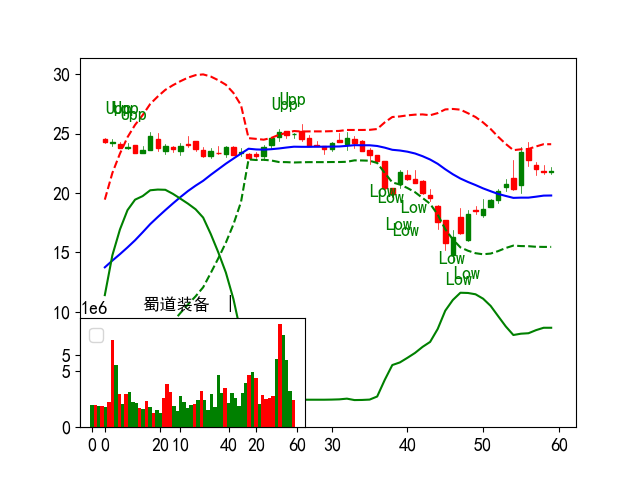

In [76]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [77]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.couts > 1][:20])
# show_tdx_data(df_mask250.loc[code_t])

(551, 31)

count dd.couts
(code    date      
603556  2024-01-17    4
603019  2024-02-28    4
        2024-02-29    4
Name: couts, dtype: int64, (267, 32))
compute percent
df_mask250:174 df_mask_hmax:189
cross_hamx:66
Count:20 41


name  couts       date   perc  ra_diff  xratio    idx    hat   close  \
code                                                                           
300757  罗博特科      2 2024-03-04  12.86     2.64    1.18  44.04  69.71  122.88   
000628  高新发展      2 2024-03-05   1.91     2.62    1.92  38.35  69.03   90.02   
603129  春风动力      2 2024-03-06   4.90     1.46    0.96  22.29  35.91  118.39   
603728  鸣志电器      2 2024-03-01   4.62     1.86    0.52  20.77  32.43   59.30   
603019  中科曙光      4 2024-03-04   2.95     1.79    0.84  17.34  30.47   54.50   
300567  精测电子      2 2024-03-04   0.15     1.55    0.05  17.03  24.63   71.53   
300870   欧陆通      2 2024-03-04   0.53     1.87    0.39  16.77  24.21   47.42   
003031  中瓷电子      2 2024-03-04   0.03     1.54    0.42  15.03  27.65   76.15   
300856  科思股份      3 2024-03-06   6.56     1.39    0.29  13.48  19.79   76.49   
000733  振华科技      2 2024-03-01   1.40     1.41    0.32  11.54  17.57   55.88   
603220  中贝通信      2 2024-03-04  -2.67     1.81    0.36  10.95  18.74   34.59   
002875   安奈儿      3 2024-03-06   9.98     2.69    0.28  10.75  14.84   21.26   
300042  朗科科技      2 2024-03-04   1.41     1.52    0.02  10.66  12.19   33.87   
002281  光迅科技      3 2024-03-06   6.85     1.87    0.55  10.51  20.33   37.90   
300274  阳光电源      2 2024-03-06   4.10     1.24    0.32  10.18  15.12   94.28   
000977  浪潮信息      2 2024-03-04  -0.55     1.57    0.40   9.81  17.31   41.83   
301018  申菱环境      2 2024-03-04   1.96     1.83    0.12   9.51  12.57   28.16   
300735  光弘科技      4 2024-03-06   7.22     1.89    0.33   9.42  14.06   27.18   
601595  上海电影      3 2024-03-05  -5.55     1.65    0.26   8.80  14.51   30.79   
000938  紫光股份      3 2024-03-04  -0.73     1.73    0.28   8.11  11.84   24.59   

        volsum5d  ...  ma250  nclose    llow   vol1d    vol2d  vol3d   vol4d  \
code              ...                                                          
300757     100.4  ...  94.40  119.15   97.88   15.82    44.25  15.19   13.05   
000628      20.6  ...  14.53   89.05   81.00   22.87    -4.73 -27.22    9.45   
603129      11.1  ...  34.34  114.83  111.20  -19.58    54.99 -23.95   31.54   
603728      46.1  ...  27.89   57.86   57.60    6.62   -18.12  18.04  -16.11   
603019     138.8  ...  14.19   53.64   51.87  -13.20    -8.64 -10.40  192.57   
300567     129.1  ...  31.60   70.38   68.00    6.82   100.89  13.01    7.55   
300870     262.4  ...  21.80   47.32   51.00   27.93    77.28 -29.83  114.92   
003031     149.8  ...  29.84   75.18   76.98  107.29    17.60 -20.93   28.49   
300856      20.0  ...  39.13   72.76   69.80    3.65   -12.01  34.84   14.87   
000733     173.6  ...  17.85   55.76   56.80  -22.34     8.29  21.93  165.79   
603220      10.0  ...  13.85   34.71   33.83  -11.68    -4.26   1.95   27.55   
002875    1406.0  ...  16.63   21.26   21.26  -92.59  1536.50  34.56  -49.79   
300042      26.9  ...  15.37   33.17   35.00    0.25    19.91 -20.73   37.43   
002281     109.0  ...  11.49   37.54   35.66  -18.82    79.19 -15.22    5.43   
300274      11.6  ...  25.65   92.77   89.50   30.14     4.18  13.13  -15.09   
000977     121.3  ...  10.37   41.56   42.18   44.48    53.74 -28.21   10.08   
301018     106.0  ...  21.62   27.84   26.65  105.48     6.17 -35.80   34.86   
300735      67.5  ...  12.18   26.47   24.35  -15.84    19.93 -26.20   59.99   
601595      75.2  ...  10.58   31.03   31.71   80.18   -19.59  10.53  -14.48   
000938     174.1  ...  10.38   24.49   23.79   18.11    24.77   3.99   61.64   

        vol5d  perc3d  perc5d  
code                           
300757  12.09   59.19   66.73  
000628  20.21   19.67   26.86  
603129 -31.95   13.71   18.38  
603728  55.66    6.38   23.20  
603019 -21.51   13.37   29.34  
300567   0.81   24.24   27.83  
300870  72.09   30.19   39.54  
003031  17.33   19.08   18.43  
300856 -21.32   13.79   22.72  
000733  -0.02    8.66   20.04  
603220  -3.61   20.88   23.29  
002875 -22.73   33.12   61.06  
300042  -9.93   15.39   18.96  
002281

df_mask250:57
300757 2.87
xratio:-0.09 ra_diff:2.87
code: 300757


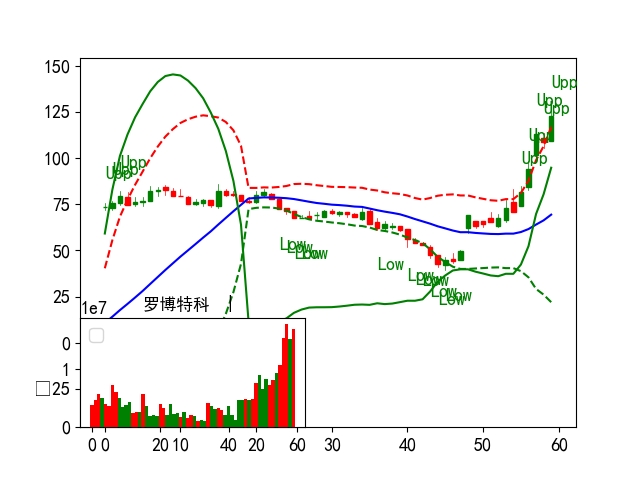

000628 2.67
xratio:0.13 ra_diff:2.67
code: 000628


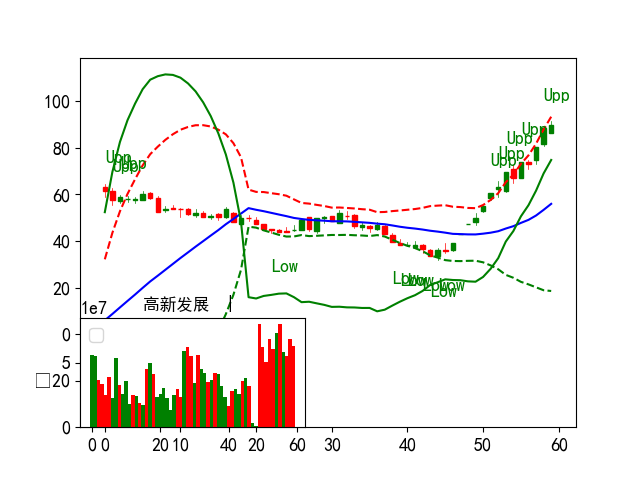

603129 1.46
xratio:0.16 ra_diff:1.46
code: 603129


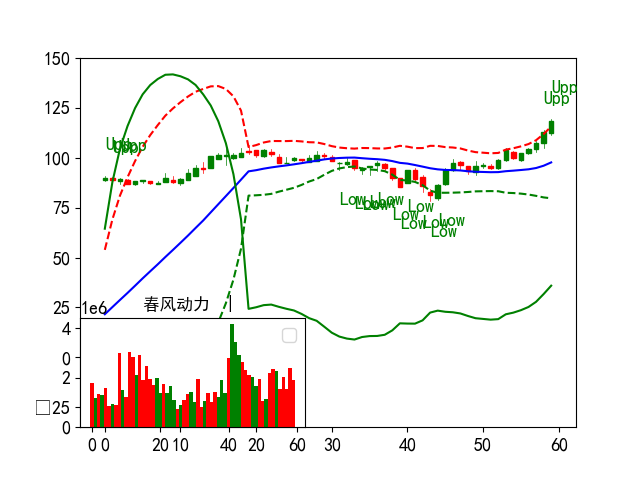

603728 1.84
xratio:-0.47 ra_diff:1.84
code: 603728


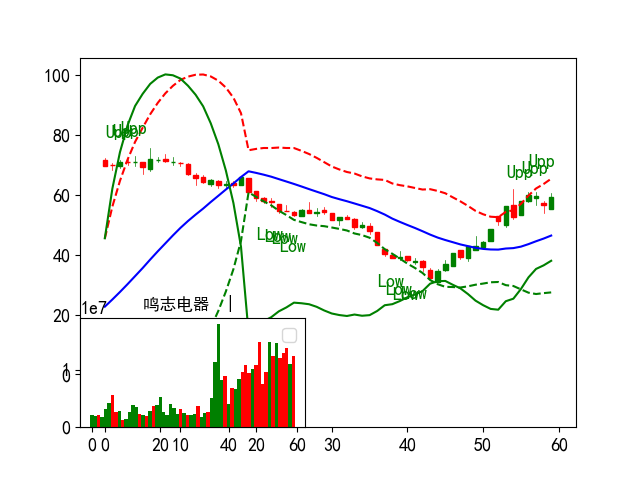

603019 1.81
xratio:0.07 ra_diff:1.81
code: 603019


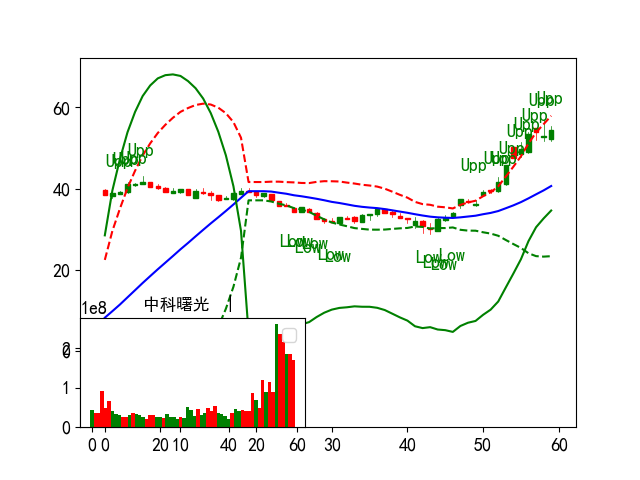

300567 1.49
xratio:-0.59 ra_diff:1.49
code: 300567


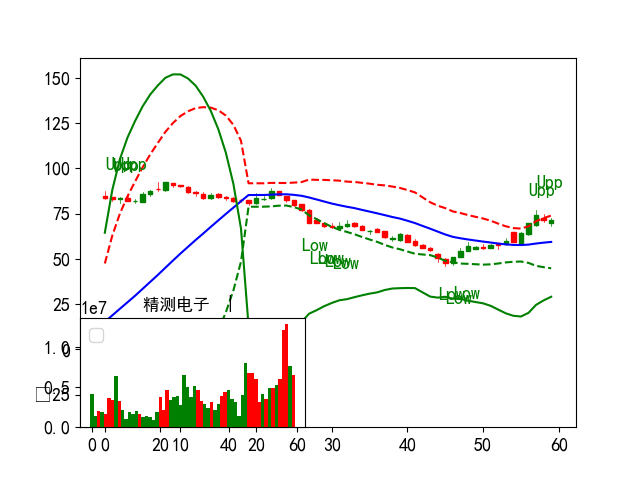

300870 1.72
xratio:-0.15 ra_diff:1.72
code: 300870


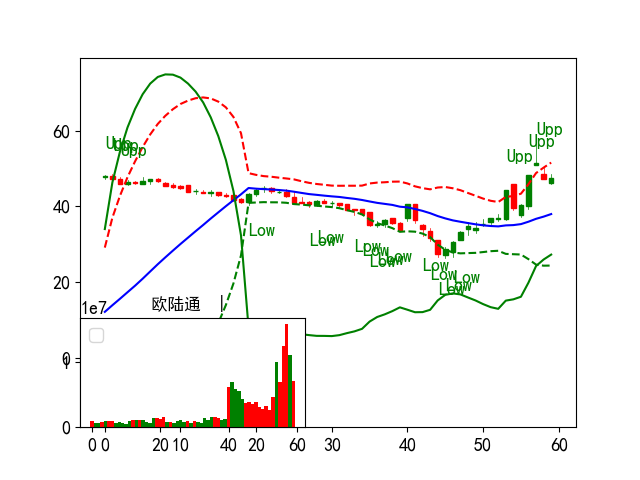

003031 1.48
xratio:-0.54 ra_diff:1.48
code: 003031


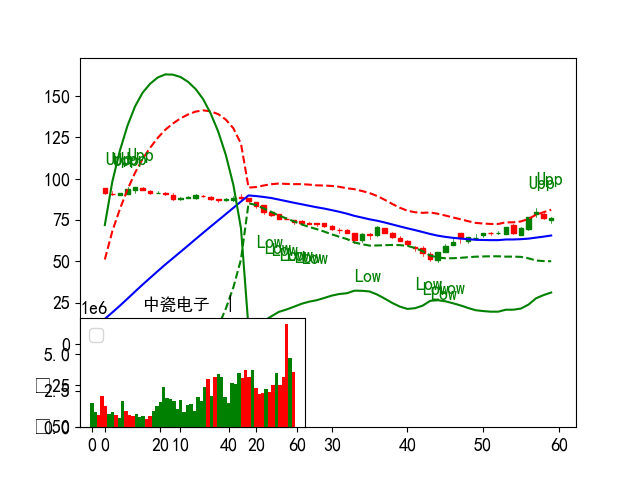

300856 1.39
xratio:0.05 ra_diff:1.39
code: 300856


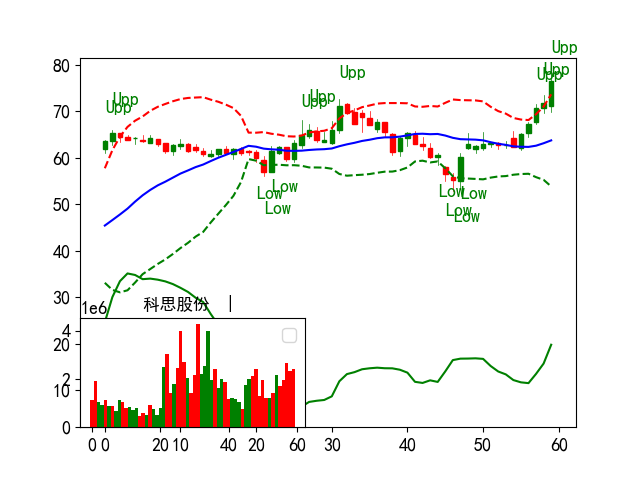

000733 1.34
xratio:-0.2 ra_diff:1.34
code: 000733


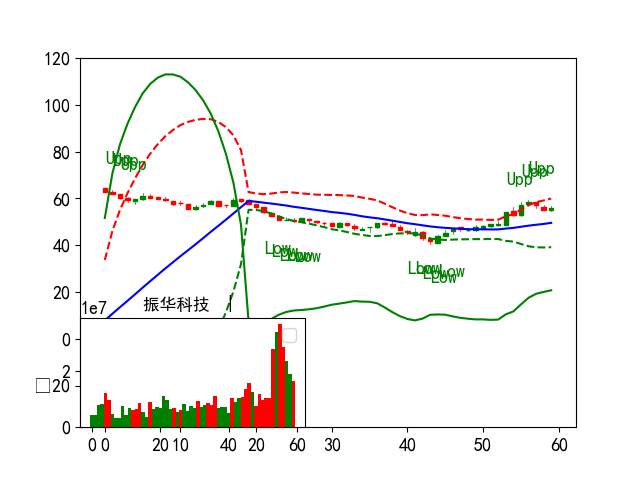

In [78]:
print("df_mask250:%s"%(len(df_mask250[df_mask250.couts > 1])))
for co in df_mask250[df_mask250.couts > 1].index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [79]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date   lopen   lhigh   llow   close         vol        amount  \
code                                                                         
300757 2024-03-04  101.88  113.04  97.88  122.88  17928614.0  1.906178e+09   
000628 2024-03-05   81.50   88.33  81.00   90.02  68078744.0  5.882298e+09   

        ra_diff   ma10    ma5  ...    idx  couts  nclose  name    open   high  \
code                           ...                                              
300757     2.64  76.31  86.61  ...  44.04      2  119.15  罗博特科  109.50  128.4   
000628     2.62  68.09  76.51  ...  38.35      2   89.05  高新发展   86.57   91.5   

           low  llastp            ticktime   perc  
code                                               
300757  109.01  108.88 2024-03-06 15:00:00  12.86  
000628   86.50   88.33 2024-03-06 15:00:00   1.91  

[2 rows x 41 columns]

(140, 41)

In [80]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(174, 41)  lastd:(43, 41) 
code
300290    荣科科技
603327    福蓉科技
002875     安奈儿
301213    观想科技
301313    凡拓数创
600593    大连圣亚
000801    四川九洲
600818    中路股份
601138    工业富联
600774    汉商集团
601595    上海电影
300735    光弘科技
603261    立航科技
000628    高新发展
601900    南方传媒
603131    上海沪工
300598    诚迈科技
601001    晋控煤业
003005     竞业达
600584    长电科技
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:189
002369 1.88
xratio:-0.03 ra_diff:1.88
code: 002369


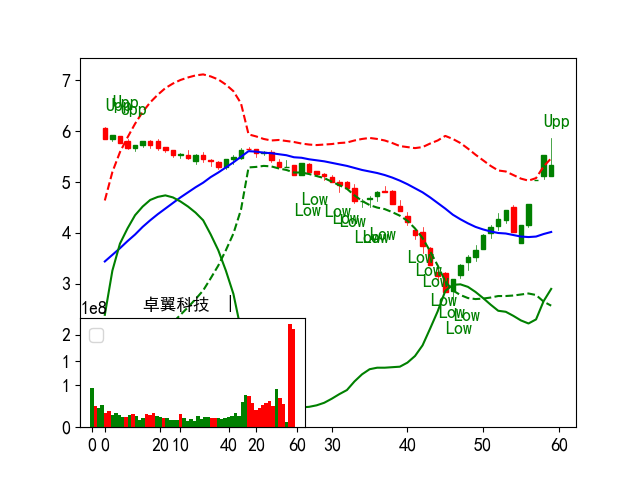

002875 2.69
xratio:-0.03 ra_diff:2.69
code: 002875


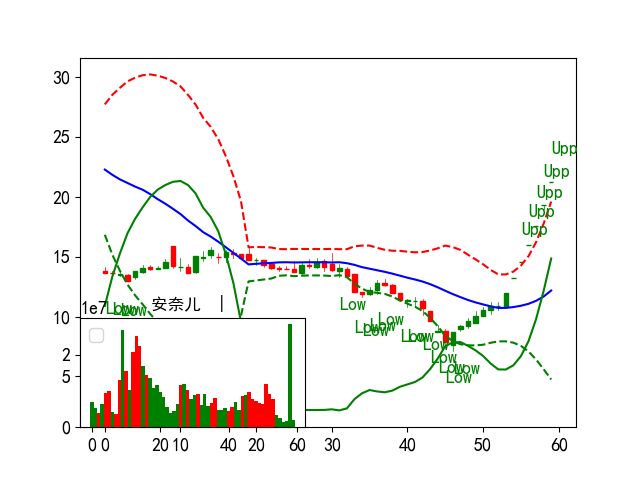

002881 1.46
xratio:-0.13 ra_diff:1.46
code: 002881


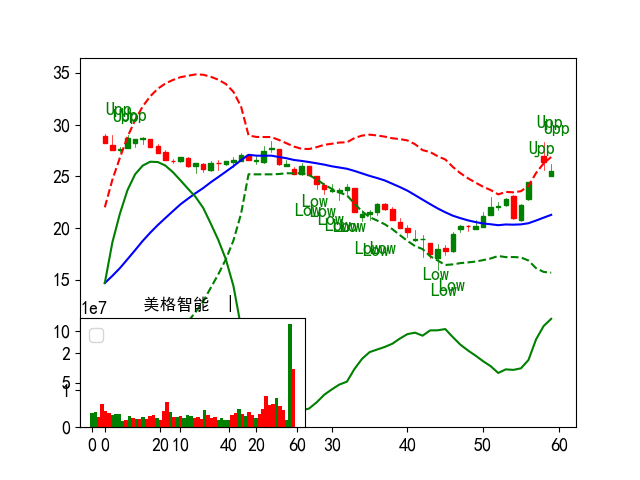

600715 2.22
xratio:-0.03 ra_diff:2.22
code: 600715


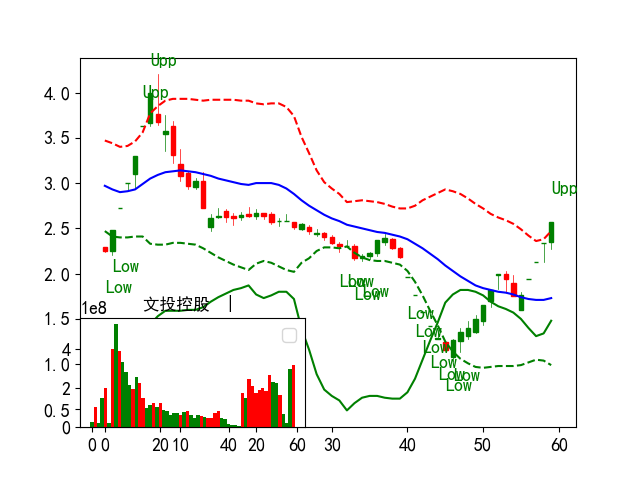

600330 1.51
xratio:-0.03 ra_diff:1.51
code: 600330


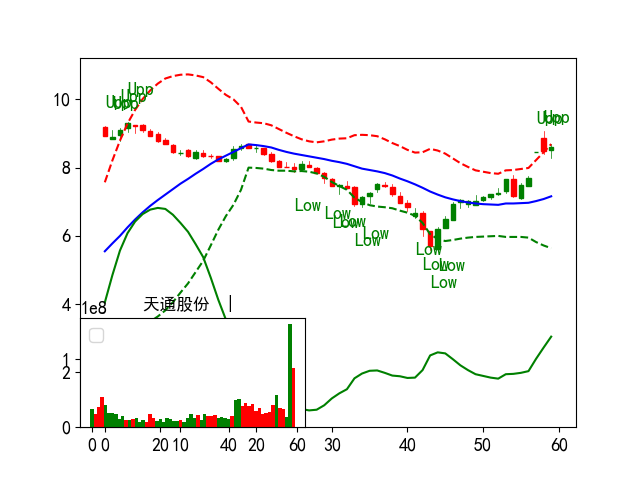

603327 2.05
xratio:-0.06 ra_diff:2.05
code: 603327


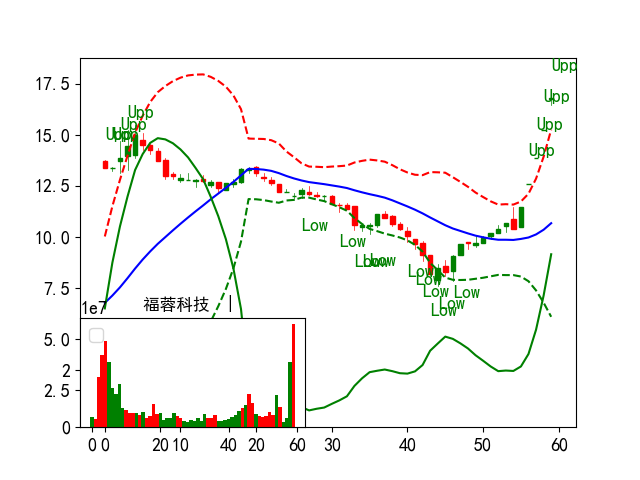

600979 1.31
xratio:-0.01 ra_diff:1.31
code: 600979


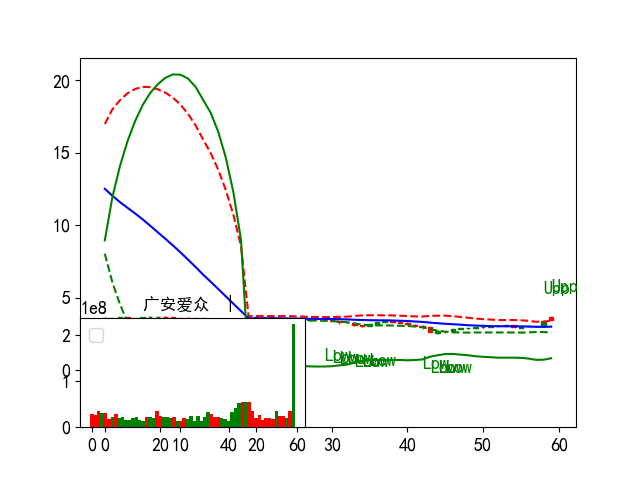

600774 1.6
xratio:-0.07 ra_diff:1.6
code: 600774


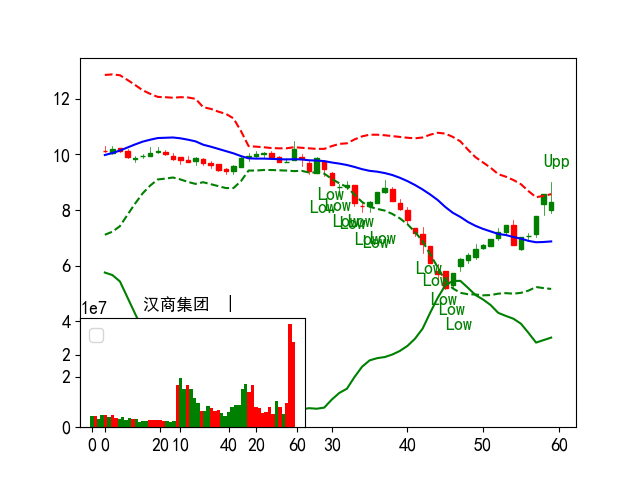

002177 1.54
xratio:-0.02 ra_diff:1.54
code: 002177


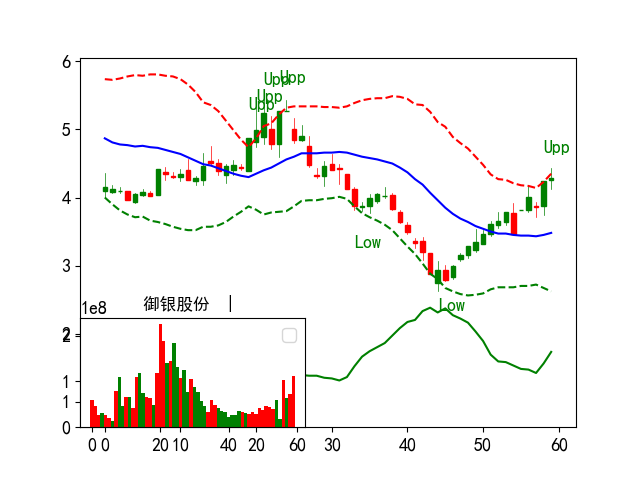

002716 1.35
xratio:-0.01 ra_diff:1.35
code: 002716


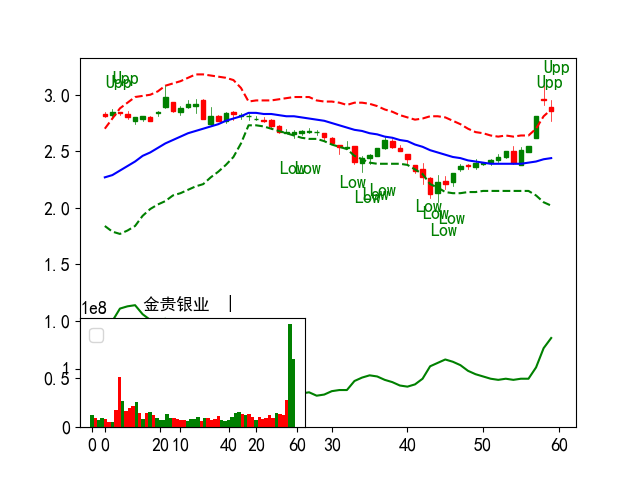

In [81]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:43
300290 2.8
xratio:-0.01 ra_diff:2.8
code: 300290


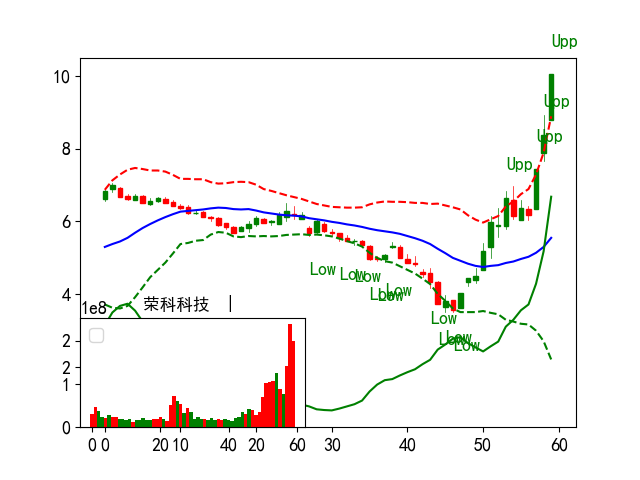

603327 2.05
xratio:-0.06 ra_diff:2.05
code: 603327


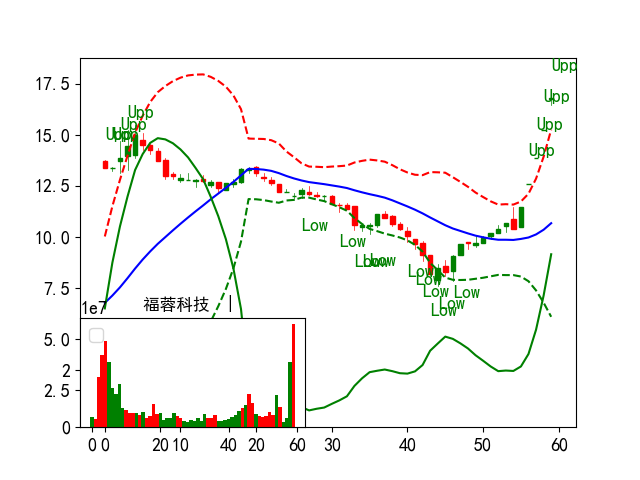

002875 2.69
xratio:-0.03 ra_diff:2.69
code: 002875


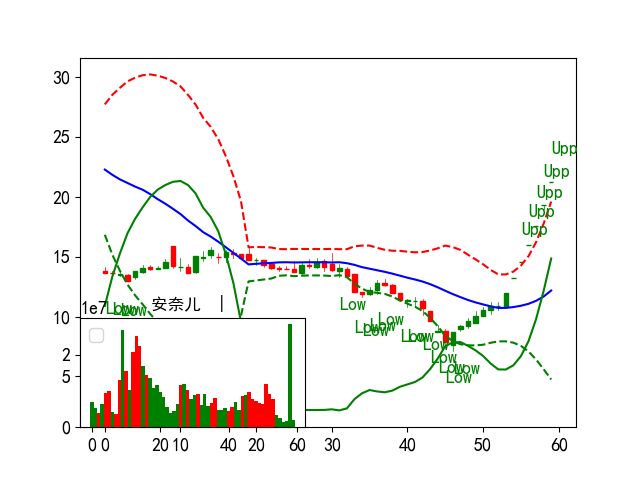

301213 1.76
xratio:-0.27 ra_diff:1.76
code: 301213


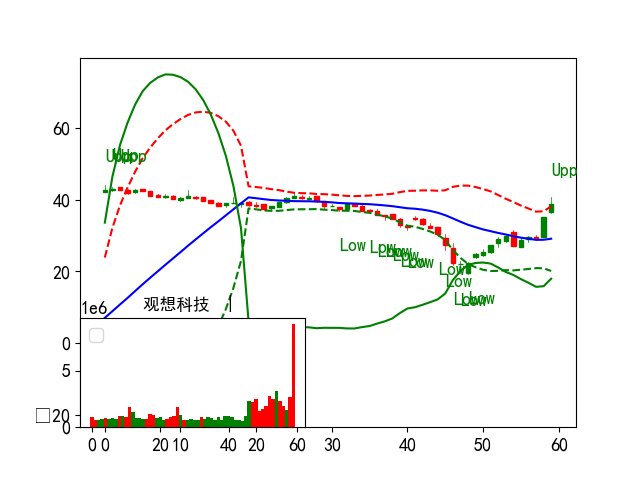

301313 1.63
xratio:-0.21 ra_diff:1.63
code: 301313


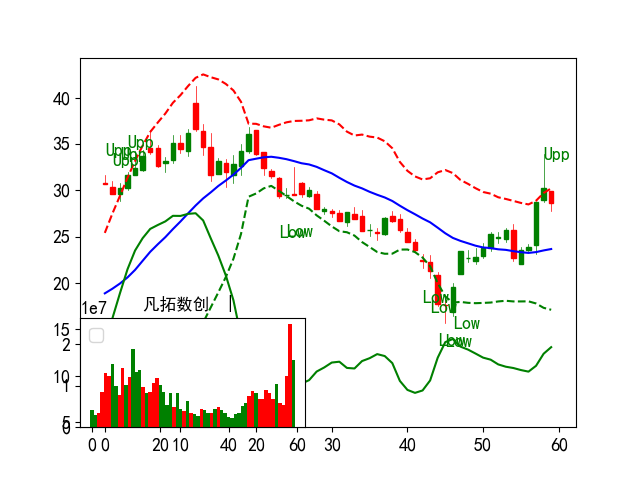

600593 1.56
xratio:-0.05 ra_diff:1.56
code: 600593


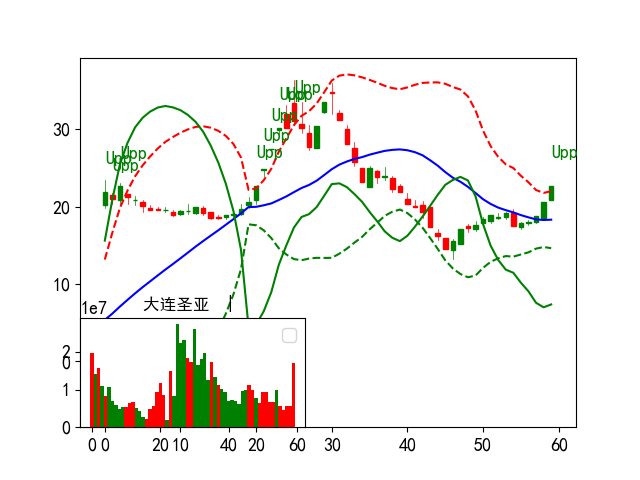

000801 1.81
xratio:0.02 ra_diff:1.81
code: 000801


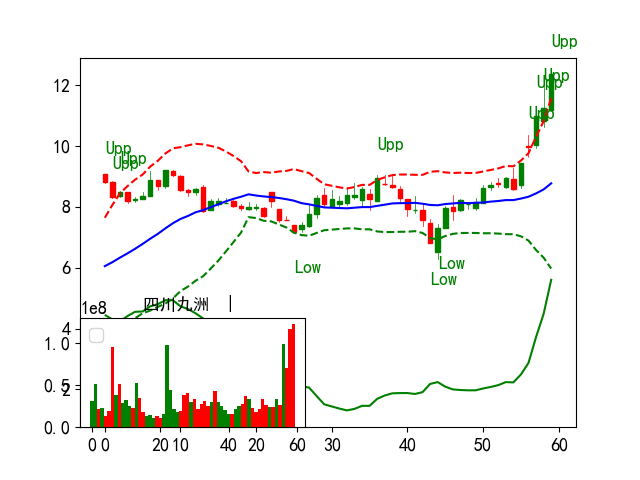

600818 2.11
xratio:-0.04 ra_diff:2.11
code: 600818


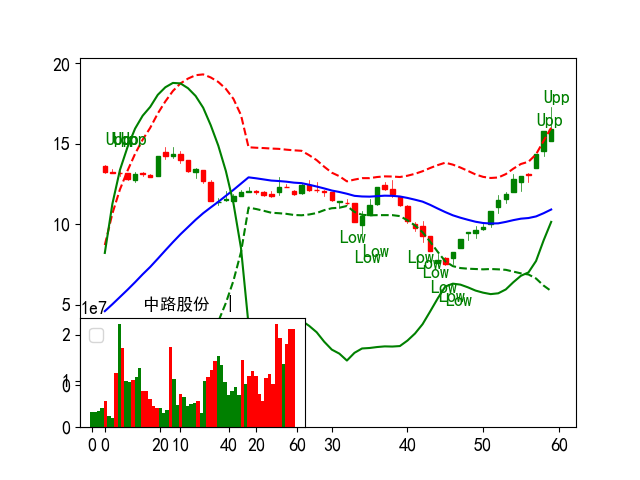

601138 1.74
xratio:0.08 ra_diff:1.74
code: 601138


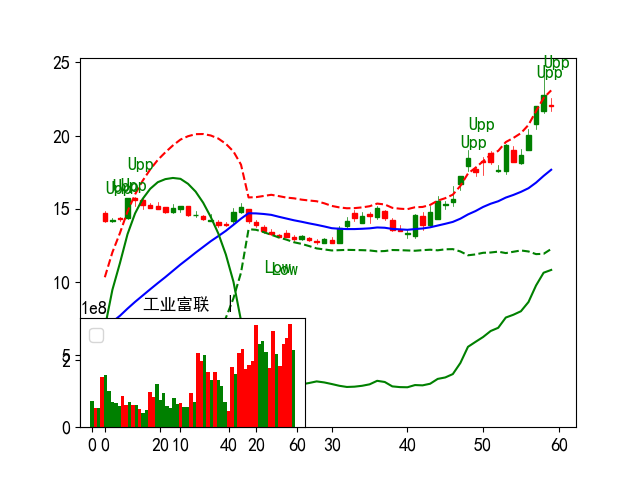

600774 1.6
xratio:-0.07 ra_diff:1.6
code: 600774


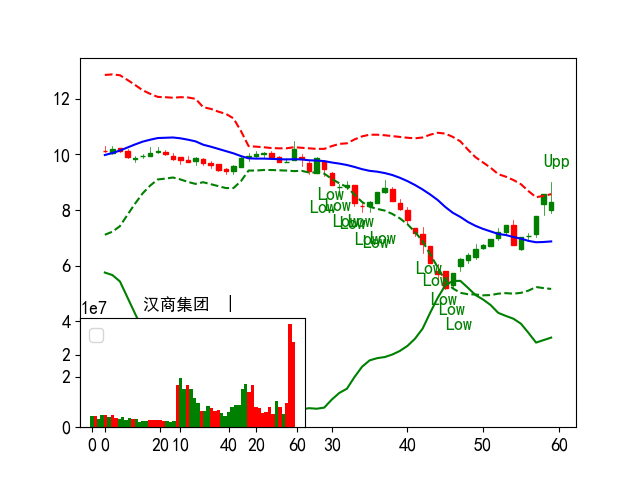

In [82]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [83]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250][:5])

cross_hamx:41
Count:5 41


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
300290  荣科科技      2 2024-03-06  19.95     2.80    0.15   4.84   6.68  10.04   
603327  福蓉科技      4 2024-03-06  10.03     2.05    0.18   6.84   9.16  16.79   
002875   安奈儿      3 2024-03-06   9.98     2.69    0.28  10.75  14.84  21.26   
301213  观想科技      1 2024-03-06  10.68     1.76   -0.14  13.49  17.97  38.87   
301313  凡拓数创      1 2024-03-05  -5.35     1.72    0.06   7.47  12.38  28.68   

        volsum5d  ...  ma250  nclose   llow   vol1d    vol2d  vol3d  vol4d  \
code              ...                                                        
300290      94.9  ...   8.19    9.77   8.80  -16.94    70.18  84.58 -14.14   
603327     641.0  ...  10.25   16.79  16.44   58.39   623.83  68.60 -73.69   
002875    1406.0  ...  16.63   21.26  21.26  -92.59  1536.50  34.56 -49.79   
301213     256.2  ...  16.85   38.05  36.18  246.78    76.56 -18.93 -18.95   
301313     237.5  ...  26.72   28.48  28.73  101.01   136.17 -10.09 -43.73   

        vol5d  perc3d  perc5d  
code                           
300290 -28.77   62.20   63.25  
603327 -36.13   33.15   61.13  
002875 -22.73   33.12   61.06  
301213 -29.28   31.32   43.33  
301313  54.10   28.61   17.72  

[5 rows x 24 columns]

df_mask250:41
300474 1.64
xratio:-0.34 ra_diff:1.64
code: 300474


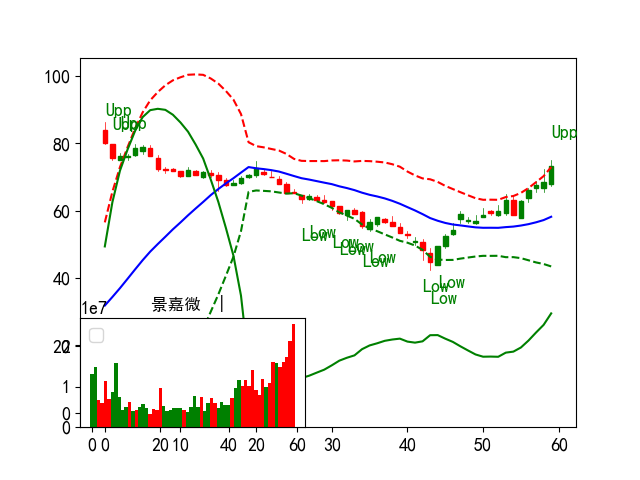

000670 1.6
xratio:-0.04 ra_diff:1.6
code: 000670


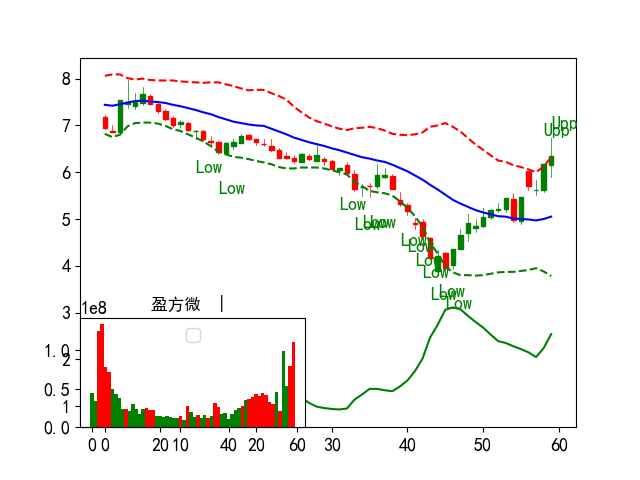

603556 1.48
xratio:0.13 ra_diff:1.48
code: 603556


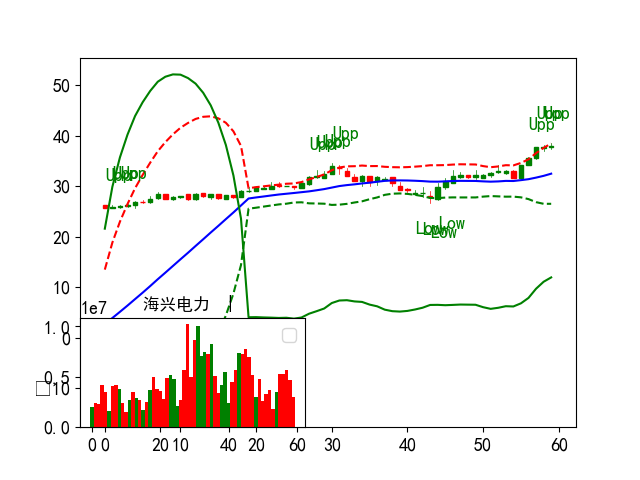

600916 1.22
xratio:0.0 ra_diff:1.22
code: 600916


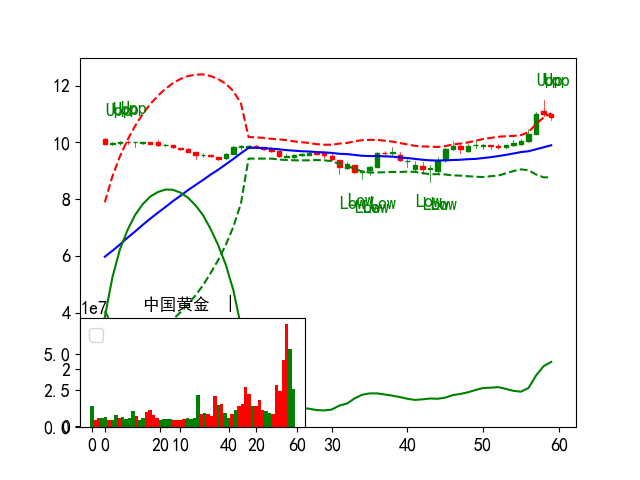

600547 1.23
xratio:-0.01 ra_diff:1.23
code: 600547


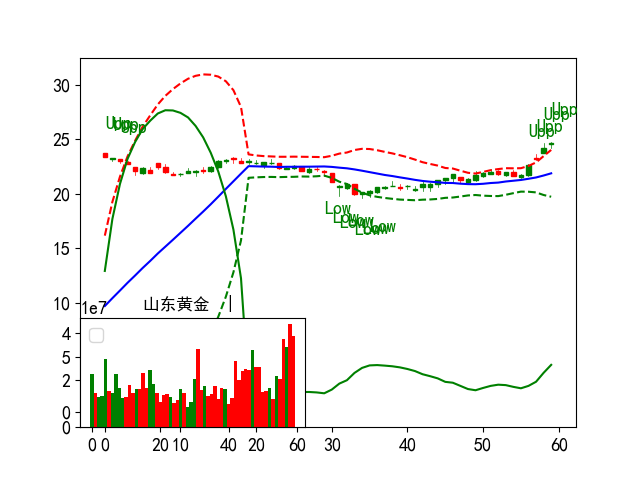

001337 1.19
xratio:-0.14 ra_diff:1.19
code: 001337


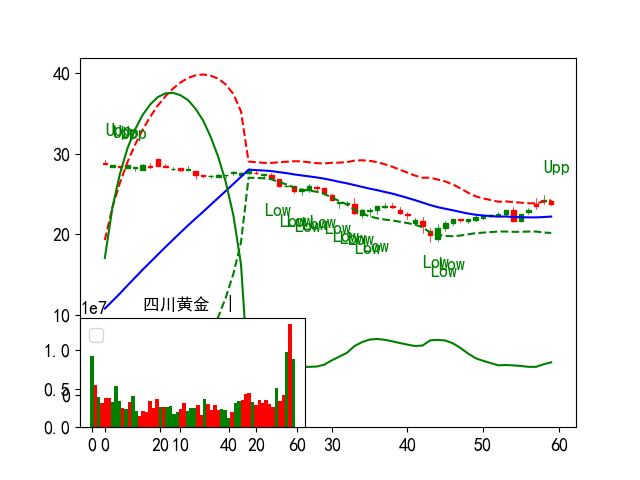

300274 1.24
xratio:0.13 ra_diff:1.24
code: 300274


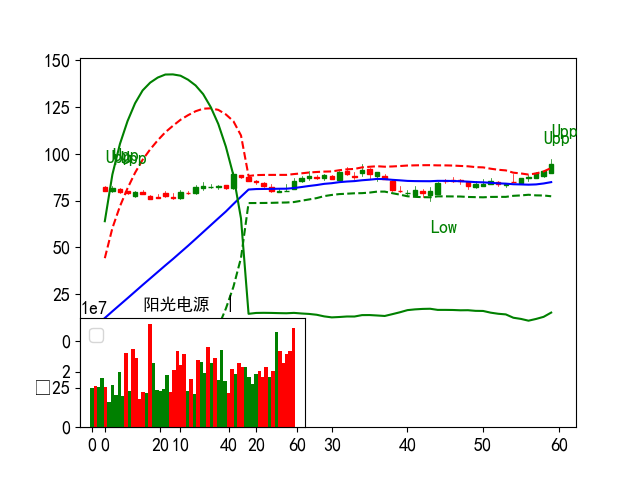

600406 1.22
xratio:0.03 ra_diff:1.22
code: 600406


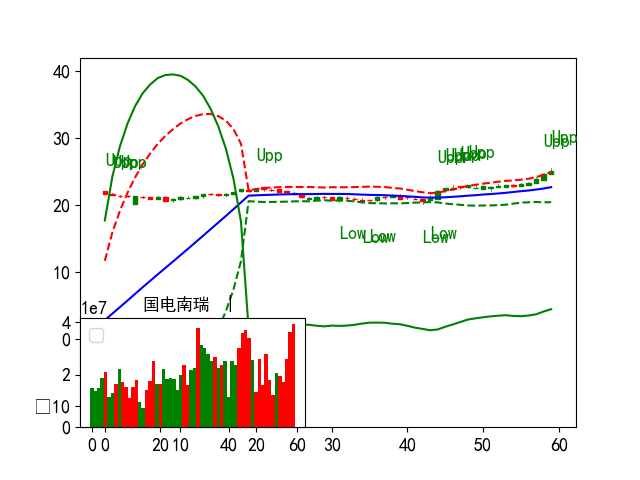

300699 1.34
xratio:0.05 ra_diff:1.34
code: 300699


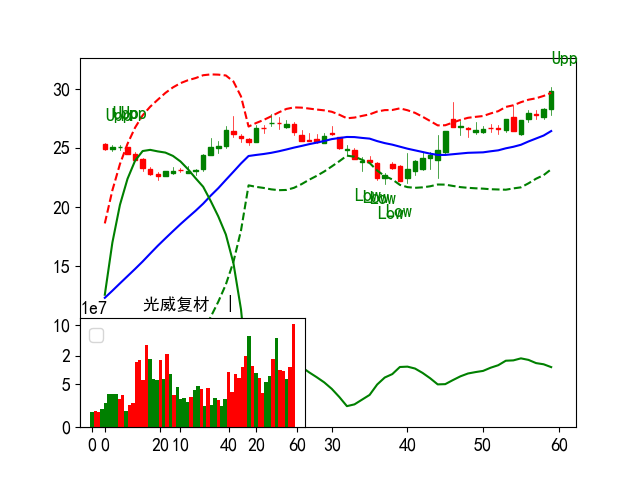

600660 1.24
xratio:0.11 ra_diff:1.24
code: 600660


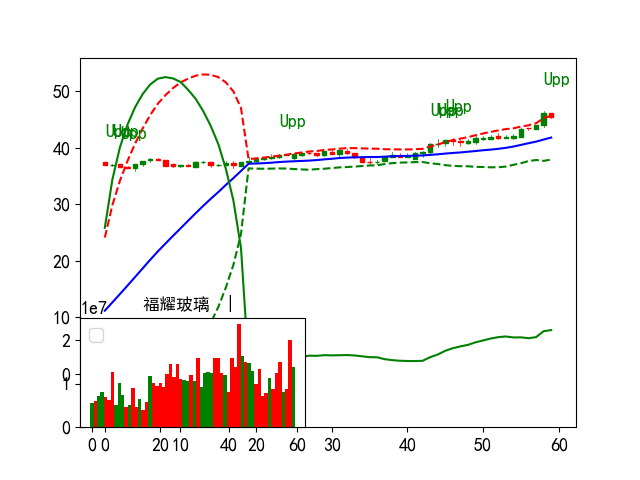

In [84]:
print("df_mask250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [85]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [86]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [87]:
top_temp.shape
top_temp.index

(762, 34)

Index(['603979', '600160', '603960', '601899', '601607', '600660', '600489',
       '300394', '601138', '600104',
       ...
       '000099', '002786', '002376', '300470', '300585', '300731', '300928',
       '300965', '300402', '301162'],
      dtype='object', name='code', length=762)

## plt.close('all')

In [88]:
# plt.close('all')

# 写入060